# Exploration of annotated data

In [147]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from os.path import join

from data.tf_record_loading import load_tf_dataset, tf_dataset_generator
from prediction.prediction_utils import load_model, run_inference_for_single_image
from prediction import predict_on_series as series_predictor
from visualization import draw_circles_on_image
from data.bbox_utils import boxes_to_center_points


In [123]:
# Set default figure size
matplotlib.rcParams['figure.figsize'] = (12, 6)

In [223]:
record_a549_path = Path(r"D:\Nabil_object_detection\data\experiments\cell_type\cross_validation\lensfree_a549.tfrecord")
record_nrk_path = Path(r"D:\Nabil_object_detection\data\experiments\cell_type\cross_validation\lensfree_nrk.tfrecord")
record_hela_path = Path(r"D:\Nabil_object_detection\data\experiments\cell_type\cross_validation\lensfree_hela.tfrecord")
record_3t3_path = Path(r"D:\Nabil_object_detection\data\experiments\cell_type\cross_validation\lensfree_3t3.tfrecord")

In [224]:
record_a549_generator = load_tf_dataset(str(record_a549_path))
record_nrk_generator = load_tf_dataset(str(record_nrk_path))
record_hela_generator = load_tf_dataset(str(record_hela_path))
record_3t3_generator = load_tf_dataset(str(record_3t3_path))

# Show mean image

In [225]:
images_a549 = np.array(record_a549_generator.get("images"))
images_nrk = np.array(record_nrk_generator.get("images"))
images_hela = np.array(record_hela_generator.get("images"))
images_3t3 = np.array(record_3t3_generator.get("images"))

In [226]:
mean_image_a549 = images_a549.mean(axis=0)
mean_image_nrk = images_nrk.mean(axis=0)

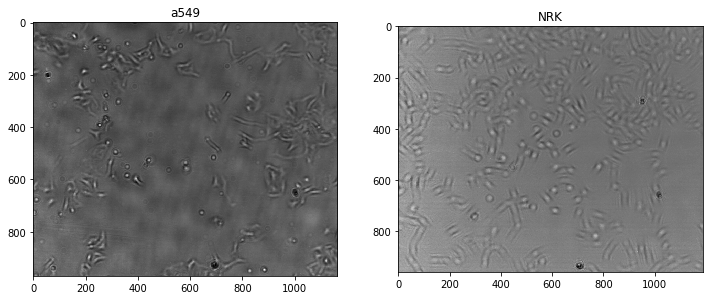

In [227]:
plt.subplot(121)
plt.title("a549")
plt.imshow(mean_image_a549, cmap="gray")
plt.subplot(122)
plt.title("NRK")
plt.imshow(mean_image_nrk, cmap="gray")
plt.show()

# Show image distribution

In [228]:
flat_3t3 = np.concatenate([i.flatten() for i in images_3t3])

In [229]:
a549_flat = images_a549.flatten()
nrk_flat = images_nrk.flatten()
hela_flat = images_hela.flatten()

In [231]:
all_lf_pixels = np.concatenate((flat_3t3, a549_flat, nrk_flat, hela_flat))

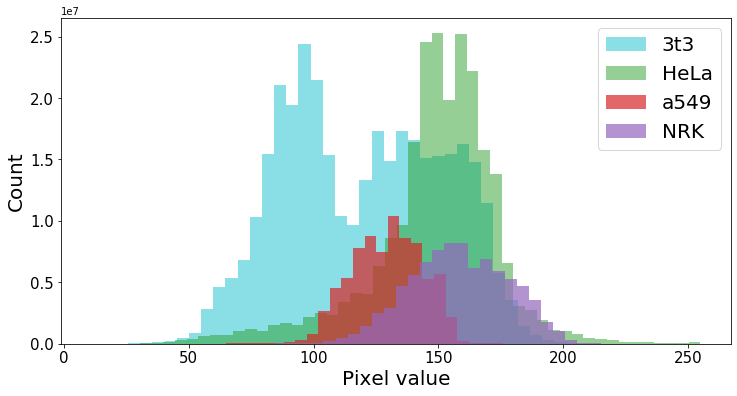

In [219]:
plt.hist(flat_3t3, bins=50, alpha=0.5, label="3t3", color="tab:cyan")
plt.hist(hela_flat, bins=50, alpha=0.5, label="HeLa", color="tab:green")
plt.hist(a549_flat, bins=50, alpha=0.7, label="a549", color="tab:red")
plt.hist(nrk_flat, bins=50, alpha=0.7, label="NRK", color="tab:purple")
plt.xlabel("Pixel value", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

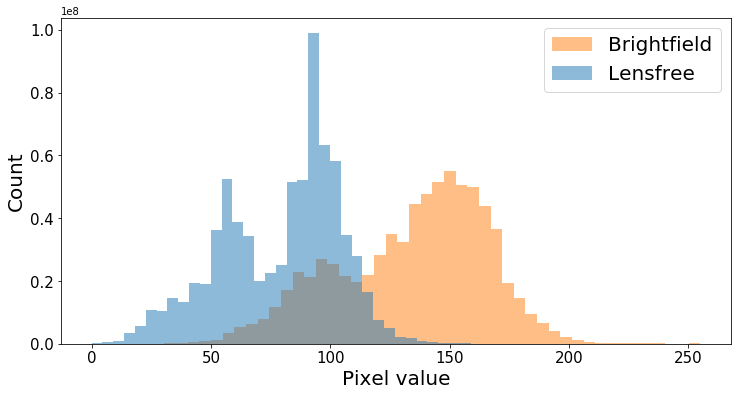

In [236]:
plt.hist(all_bf_pixels, color='#ff7f0e', label="Brightfield", bins=50, alpha=0.5)
plt.hist(all_lf_pixels, color='#1f77b4', label="Lensfree", bins=50, alpha=0.5)
plt.xlabel("Pixel value", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [232]:
all_lf_pixels.shape

(750092796,)

In [233]:
all_bf_pixels.shape

(750233736,)

# Show prediction

In [152]:
model_path = Path(r"D:\Nabil_object_detection\models\graph_data_size_cv\ssd_lensfree_a549")
model = load_model(model_path)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [177]:
a549_image_path = Path(r"D:\Nabil_object_detection\data\annotations\a549\20200313_A549_Hoechst_CTO_24-well_Pos06\lensfree")
a540_images = list(a549_image_path.glob("*.png"))
height, width = cv2.imread(str(a540_images[0]), 0).shape

In [184]:
def save_video_prediction(predictor, width, height, out_dir):
    out_path = str(Path(out_dir).joinpath("predictions.avi"))
    vid_cod = cv2.VideoWriter_fourcc(*"XVID")

    video = cv2.VideoWriter(out_path, vid_cod, 5, (width, height))
    for prediction in predictor:
        prediction = cv2.cvtColor(prediction, cv2.COLOR_RGB2BGR)
        video.write(prediction)
    video.release()

In [190]:
def image_predictor(path, model):
    path = Path(path)
    for image_path in path.glob("*.png"):
        image = cv2.imread(str(image_path))
        prediction = run_inference_for_single_image(model, image)
        bboxes = prediction.get("detection_boxes")[prediction.get("detection_scores") >= 0.2]
        points = boxes_to_center_points(bboxes)
        image = draw_circles_on_image(image, points)
        yield image

In [191]:
predictor = image_predictor(a549_image_path, model)
save_video_prediction(predictor, width, height, "D:\\Nabil_object_detection")